# Imports

In [1]:
import json
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import os

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix

from ddagl import graph_level_nn, graph_feature_extraction, evaluation

Using backend: pytorch


# Data Acquisition

In [2]:
if not os.path.exists('datasets/odds/ODDS.json'):
    from urllib import request
    request.urlretrieve('https://zenodo.org/record/4633704/files/ODDS.json',
                        'datasets/odds/ODDS.json')

with open('datasets/odds/ODDS.json', 'r') as fp:
    graphs = pd.Series(list(map(nx.node_link_graph, json.load(fp)['graphs'])), dtype=object)

In [3]:
relevant_graphs_sub = evaluation.version_subsampling(graphs, subsampling_factor=10)
del graphs

cr_graphs, cr_labels = evaluation.prepare_for_component_refinement(relevant_graphs_sub, 
                                                                   drop_attrs=('config', 'name', 'description'))
del relevant_graphs_sub
groups = [g.graph['id'] for g in cr_graphs]
cr_nodes = [g.graph['node'] for g in cr_graphs]

# Setup

In [4]:
cv = GroupShuffleSplit(random_state=42)

def cv_score(est, X, y, groups=groups, cv = cv, show_training_history: bool = False, plot_predictions:bool = False,
            set_est_random_state:bool = True, print_results:bool = True):  
    score_dicts = []
    for random_state, (train_ind, test_ind) in enumerate(cv.split(X, y, groups=groups)):
        X_train, y_train = X[train_ind], y[train_ind]
        X_test, y_test = X[test_ind], y[test_ind]
        if set_est_random_state and type(est) is Pipeline and hasattr(est.steps[-1][-1], 'random_state'):
            est.steps[-1][-1].random_state = random_state
            
        est.fit(X_train, y_train)
        
        if show_training_history and type(est) is Pipeline and hasattr(est.steps[-1][-1], 'show_training_history'):
            est.steps[-1][-1].show_training_history(figsize=(8, 5), epoch_cutoff=.5)
            plt.show()
        
        y_pred = est.predict(X_test)
        top_5_accuracy = top_n_scorer(est, X_test, y_test)
        accuracy = accuracy_score(y_test, y_pred)
        score_dicts.append(dict(accuracy=accuracy, top_5_accuracy=top_5_accuracy))
        print(score_dicts[-1])
        if plot_predictions:
            plt.figure(figsize = (7,6), dpi = 200)
            sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), cmap='Blues', square=True)
            plt.show()
    
    scores_df = pd.DataFrame(score_dicts)
    if print_results:
        print(scores_df.aggregate((np.mean, np.std)))
    return scores_df

# Basic Classifiers

In [8]:
nlfe = graph_feature_extraction.NodeLevelFeatureExtractor(n_jobs=16)
if not os.path.exists('cr_node_level_df.csv'):
    node_level_df = nlfe.fit_transform(zip(cr_graphs, cr_nodes))
    node_level_df.to_csv('cr_node_level_df.csv')
else:
    node_level_df = pd.read_csv('cr_node_level_df.csv')

In [13]:
dc = DummyClassifier(strategy='prior')
sgd_pipeline = make_pipeline(StandardScaler(), SGDClassifier(n_jobs = 4, loss='log'))
rf = RandomForestClassifier(random_state=42, n_jobs = 4)

clfs = [rf, sgd_pipeline, dc]
                  
score_dfs = []

for clf in clfs:
    name = clf.steps[-1][-1].__class__.__name__ if type(clf) is Pipeline else clf.__class__.__name__
    score_df = cv_score(clf, node_level_df.values, y=cr_labels, print_results=False)
    score_df['classifier'] = name
    score_dfs.append(score_df)                  
classifier_comparison_df = pd.concat(score_dfs)
del node_level_df

{'accuracy': 0.4798418292787759, 'top_5_accuracy': 0.6704203558841227}
{'accuracy': 0.5277777777777778, 'top_5_accuracy': 0.6987179487179487}
{'accuracy': 0.48423778428281916, 'top_5_accuracy': 0.7405989641972529}
{'accuracy': 0.6125836680053548, 'top_5_accuracy': 0.7871485943775101}
{'accuracy': 0.6294046172539489, 'top_5_accuracy': 0.7929526123936816}
{'accuracy': 0.23184045388120003, 'top_5_accuracy': 0.4409868477606808}
{'accuracy': 0.31517094017094016, 'top_5_accuracy': 0.5809294871794872}
{'accuracy': 0.1686557081738347, 'top_5_accuracy': 0.47061472641297003}
{'accuracy': 0.36091030789825973, 'top_5_accuracy': 0.5775100401606426}
{'accuracy': 0.3543134872417983, 'top_5_accuracy': 0.6522478736330498}
{'accuracy': 0.26390440986847763, 'top_5_accuracy': 0.44949712026132554}
{'accuracy': 0.28872863247863245, 'top_5_accuracy': 0.4391025641025641}
{'accuracy': 0.13870749831119117, 'top_5_accuracy': 0.41904976356676427}
{'accuracy': 0.24123159303882197, 'top_5_accuracy': 0.4666666666666

In [14]:
classifier_comparison_df.groupby('classifier').aggregate(['mean', 'std']).sort_values(('top_5_accuracy', 'mean'))

accuracy           top_5_accuracy          
                            mean       std           mean       std
classifier                                                         
DummyClassifier         0.245469  0.063361       0.451583  0.024854
SGDClassifier           0.286178  0.083415       0.544458  0.086891
RandomForestClassifier  0.546769  0.070552       0.737968  0.053741

# P-GCN

## Setup

In [5]:
feature_transformer = graph_feature_extraction.NodeLevelFeatureTransformer(use_configs=False, 
                                                                           node_id_column = 'node')
gcn_default_kwargs = dict(nb_epochs=50, random_state=42, batch_size = 5000, inference_batch_size = 500,
                          scoring = accuracy_score, dropout = 0.25)

## Hybrid P-GCN

epoch 000 | lr 0.01000 | loss 3.33219 | loss_std 0.63500 | train_score 0.23704
epoch 001 | lr 0.00950 | loss 2.49850 | loss_std 0.17533 | train_score 0.35969
epoch 002 | lr 0.00903 | loss 1.97414 | loss_std 0.12067 | train_score 0.47449
epoch 003 | lr 0.00857 | loss 1.66355 | loss_std 0.07967 | train_score 0.54237
epoch 004 | lr 0.00815 | loss 1.42402 | loss_std 0.05977 | train_score 0.60733
epoch 005 | lr 0.00774 | loss 1.24773 | loss_std 0.05040 | train_score 0.65592
epoch 006 | lr 0.00735 | loss 1.10249 | loss_std 0.06004 | train_score 0.68989
epoch 007 | lr 0.00698 | loss 1.01140 | loss_std 0.02933 | train_score 0.71435
epoch 008 | lr 0.00663 | loss 0.91651 | loss_std 0.02169 | train_score 0.74395
epoch 009 | lr 0.00630 | loss 0.81409 | loss_std 0.02678 | train_score 0.77234
epoch 010 | lr 0.00599 | loss 0.73237 | loss_std 0.01730 | train_score 0.79705
epoch 011 | lr 0.00569 | loss 0.67201 | loss_std 0.02423 | train_score 0.81205
epoch 012 | lr 0.00540 | loss 0.64336 | loss_std 0.0

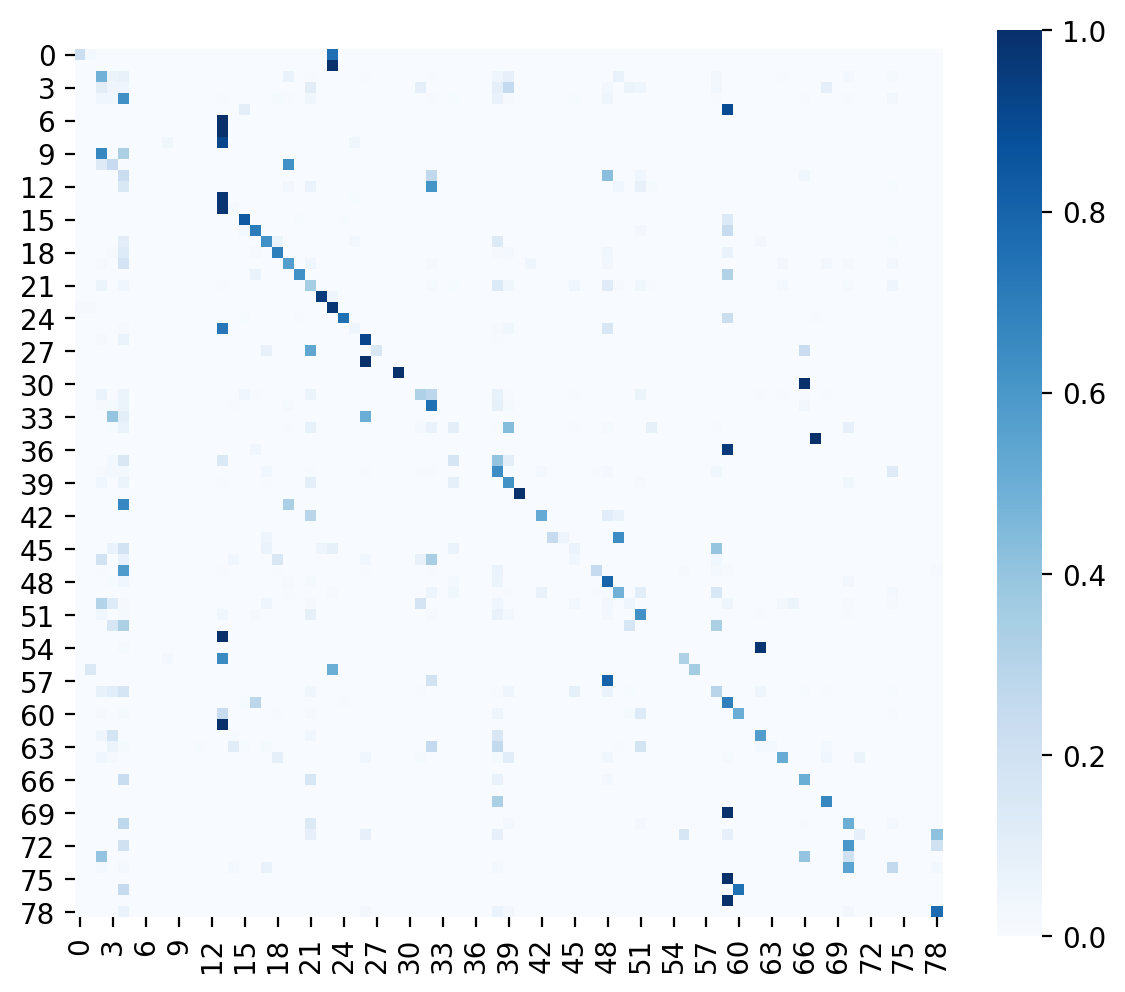

epoch 000 | lr 0.01000 | loss 3.23545 | loss_std 0.64987 | train_score 0.26036
epoch 001 | lr 0.00950 | loss 2.21686 | loss_std 0.17931 | train_score 0.42563
epoch 002 | lr 0.00903 | loss 1.71973 | loss_std 0.11821 | train_score 0.52764
epoch 003 | lr 0.00857 | loss 1.43612 | loss_std 0.08947 | train_score 0.60346
epoch 004 | lr 0.00815 | loss 1.22773 | loss_std 0.06569 | train_score 0.66323
epoch 005 | lr 0.00774 | loss 1.06439 | loss_std 0.05451 | train_score 0.70749
epoch 006 | lr 0.00735 | loss 0.93216 | loss_std 0.05357 | train_score 0.74592
epoch 007 | lr 0.00698 | loss 0.84038 | loss_std 0.04039 | train_score 0.76847
epoch 008 | lr 0.00663 | loss 0.73521 | loss_std 0.03772 | train_score 0.79973
epoch 009 | lr 0.00630 | loss 0.67792 | loss_std 0.03162 | train_score 0.81591
epoch 010 | lr 0.00599 | loss 0.59207 | loss_std 0.02686 | train_score 0.83671
epoch 011 | lr 0.00569 | loss 0.55490 | loss_std 0.03251 | train_score 0.84740
epoch 012 | lr 0.00540 | loss 0.49534 | loss_std 0.0

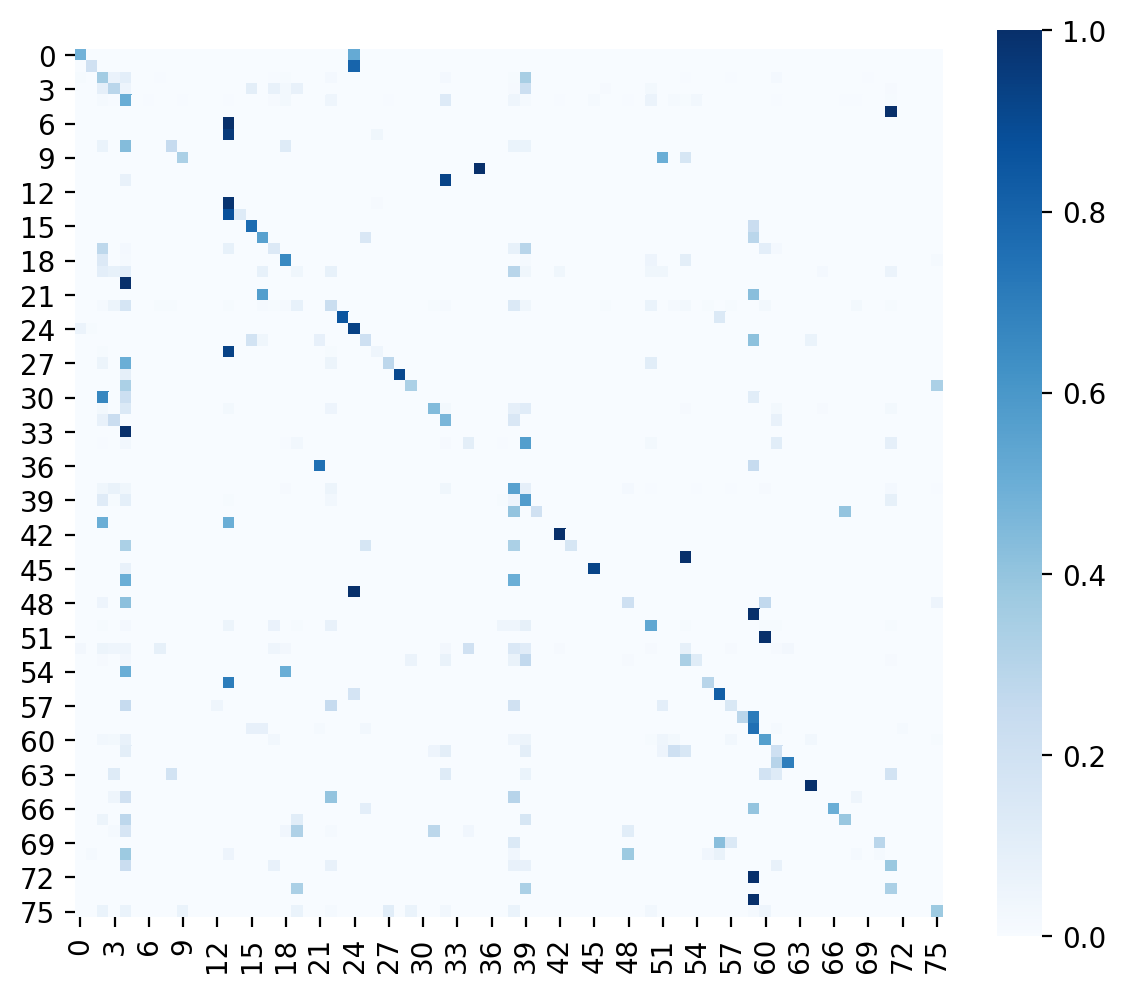

epoch 000 | lr 0.01000 | loss 3.32504 | loss_std 0.60544 | train_score 0.24965
epoch 001 | lr 0.00950 | loss 2.45865 | loss_std 0.16281 | train_score 0.36597
epoch 002 | lr 0.00903 | loss 2.03928 | loss_std 0.08612 | train_score 0.43935
epoch 003 | lr 0.00857 | loss 1.79831 | loss_std 0.06268 | train_score 0.48780
epoch 004 | lr 0.00815 | loss 1.59820 | loss_std 0.06595 | train_score 0.54281
epoch 005 | lr 0.00774 | loss 1.42105 | loss_std 0.06102 | train_score 0.59159
epoch 006 | lr 0.00735 | loss 1.29707 | loss_std 0.06953 | train_score 0.63219
epoch 007 | lr 0.00698 | loss 1.13174 | loss_std 0.04859 | train_score 0.68638
epoch 008 | lr 0.00663 | loss 0.99955 | loss_std 0.04617 | train_score 0.72324
epoch 009 | lr 0.00630 | loss 0.94286 | loss_std 0.06202 | train_score 0.73600
epoch 010 | lr 0.00599 | loss 0.84221 | loss_std 0.04094 | train_score 0.76714
epoch 011 | lr 0.00569 | loss 0.75669 | loss_std 0.03609 | train_score 0.79172
epoch 012 | lr 0.00540 | loss 0.70857 | loss_std 0.0

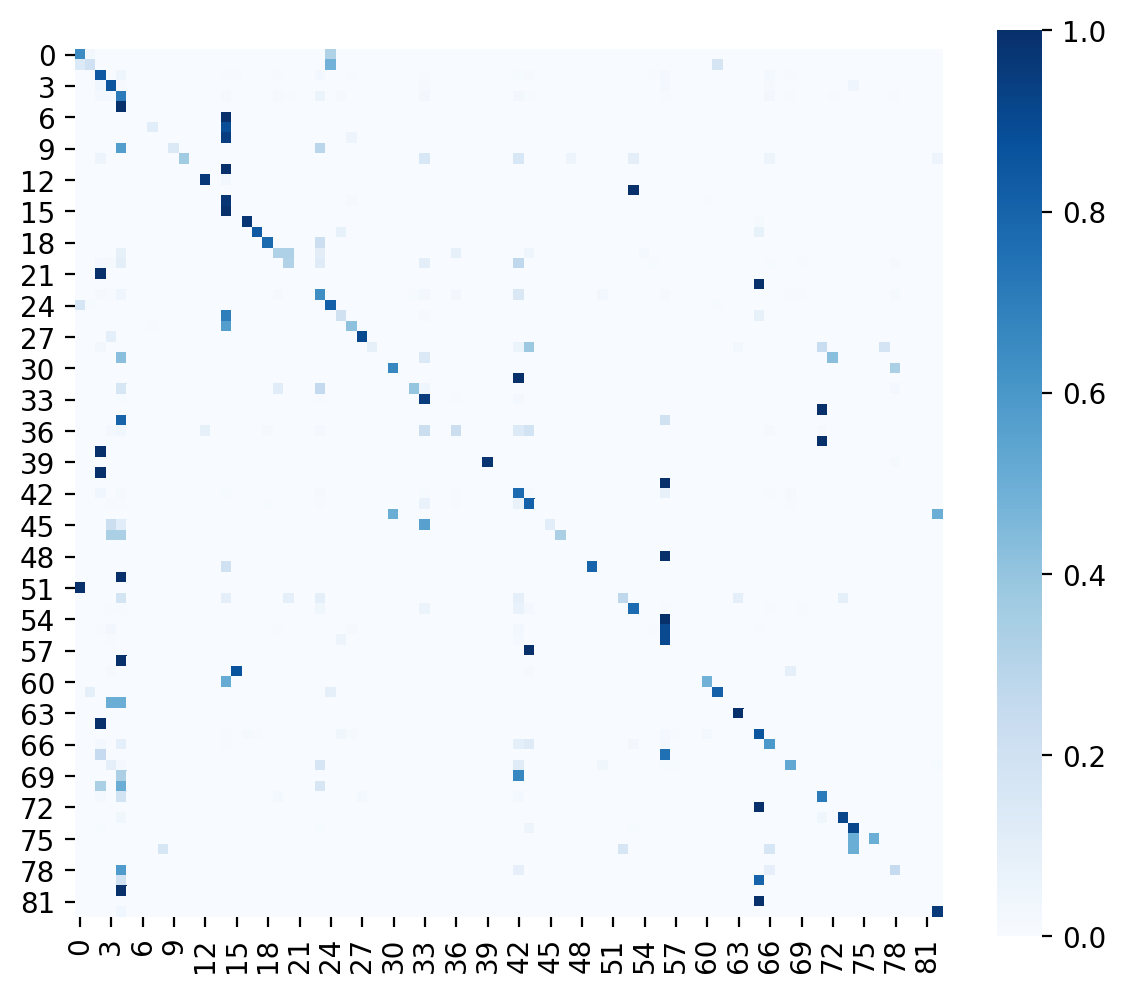

epoch 000 | lr 0.01000 | loss 3.23070 | loss_std 0.66821 | train_score 0.26283
epoch 001 | lr 0.00950 | loss 2.30527 | loss_std 0.18245 | train_score 0.40142
epoch 002 | lr 0.00903 | loss 1.85132 | loss_std 0.10389 | train_score 0.50283
epoch 003 | lr 0.00857 | loss 1.55902 | loss_std 0.09481 | train_score 0.56697
epoch 004 | lr 0.00815 | loss 1.41446 | loss_std 0.07994 | train_score 0.60543
epoch 005 | lr 0.00774 | loss 1.23491 | loss_std 0.07027 | train_score 0.65563
epoch 006 | lr 0.00735 | loss 1.03234 | loss_std 0.05407 | train_score 0.71723
epoch 007 | lr 0.00698 | loss 0.89954 | loss_std 0.06669 | train_score 0.74956
epoch 008 | lr 0.00663 | loss 0.79327 | loss_std 0.04922 | train_score 0.78155
epoch 009 | lr 0.00630 | loss 0.73913 | loss_std 0.03442 | train_score 0.79452
epoch 010 | lr 0.00599 | loss 0.70272 | loss_std 0.04213 | train_score 0.80425
epoch 011 | lr 0.00569 | loss 0.60769 | loss_std 0.03486 | train_score 0.83201
epoch 012 | lr 0.00540 | loss 0.53876 | loss_std 0.0

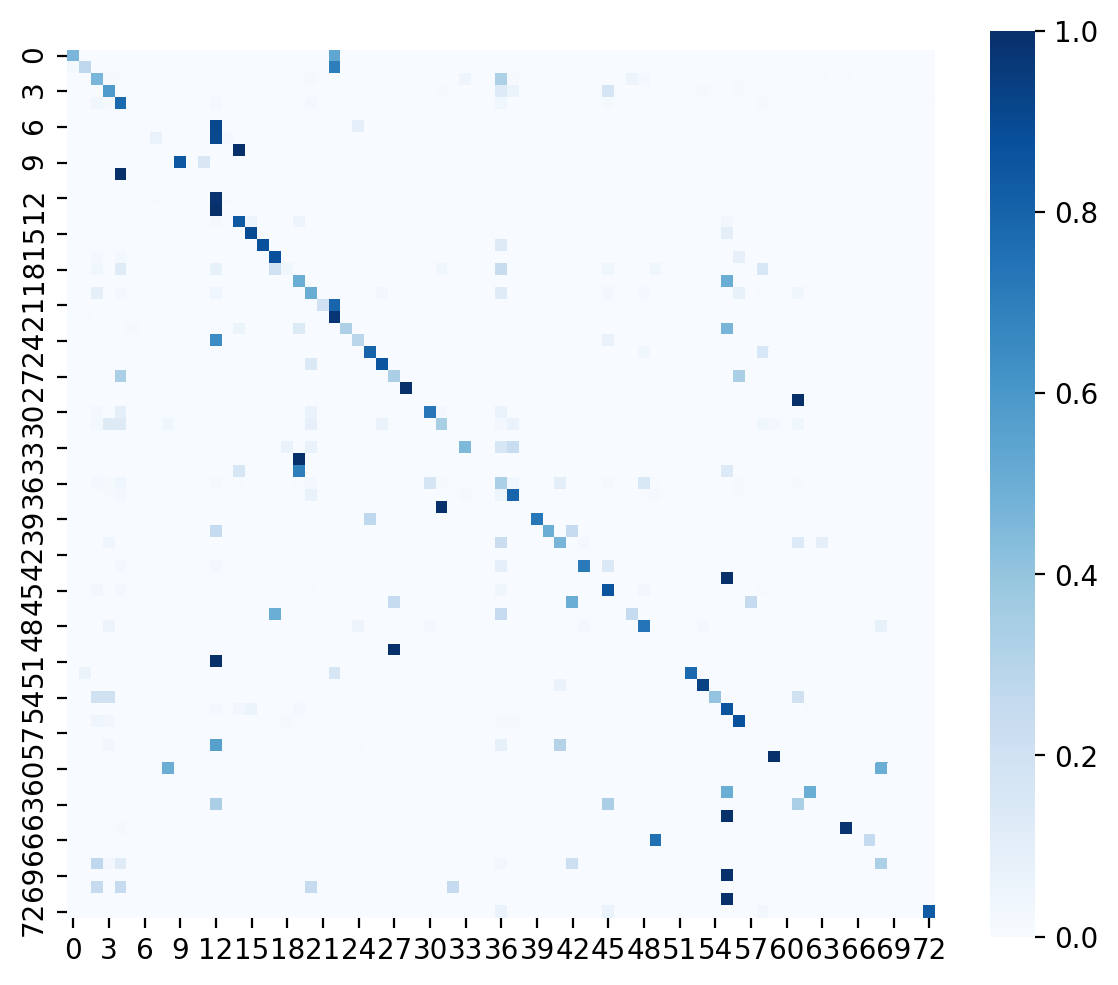

epoch 000 | lr 0.01000 | loss 3.25494 | loss_std 0.63592 | train_score 0.26282
epoch 001 | lr 0.00950 | loss 2.25084 | loss_std 0.19100 | train_score 0.42261
epoch 002 | lr 0.00903 | loss 1.76272 | loss_std 0.14608 | train_score 0.51895
epoch 003 | lr 0.00857 | loss 1.48961 | loss_std 0.07282 | train_score 0.58540
epoch 004 | lr 0.00815 | loss 1.39402 | loss_std 0.07934 | train_score 0.61195
epoch 005 | lr 0.00774 | loss 1.16480 | loss_std 0.06583 | train_score 0.67264
epoch 006 | lr 0.00735 | loss 1.00968 | loss_std 0.05953 | train_score 0.72016
epoch 007 | lr 0.00698 | loss 0.87872 | loss_std 0.06595 | train_score 0.76048
epoch 008 | lr 0.00663 | loss 0.80794 | loss_std 0.04318 | train_score 0.77813
epoch 009 | lr 0.00630 | loss 0.75096 | loss_std 0.03991 | train_score 0.79281
epoch 010 | lr 0.00599 | loss 0.67539 | loss_std 0.03600 | train_score 0.80957
epoch 011 | lr 0.00569 | loss 0.62750 | loss_std 0.03371 | train_score 0.82614
epoch 012 | lr 0.00540 | loss 0.55587 | loss_std 0.0

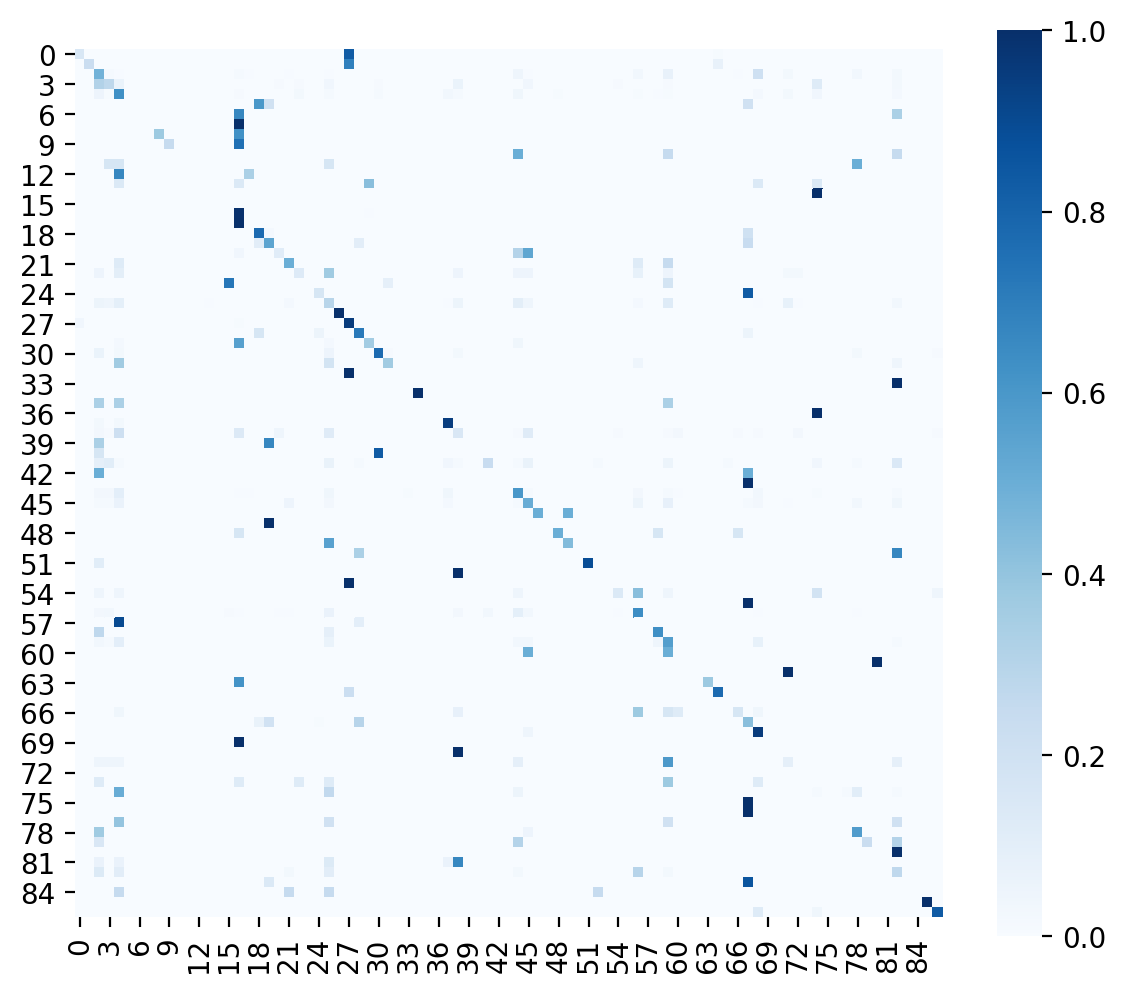

      accuracy  top_5_accuracy
mean  0.643375        0.797847
std   0.073627        0.045583


,accuracy,top_5_accuracy,classifier
0,0.624001,0.790940,Hybrid Res-GCN
1,0.547810,0.737447,Hybrid Res-GCN
2,0.752533,0.864558,Hybrid Res-GCN
3,0.657296,0.807229,Hybrid Res-GCN
4,0.635237,0.789064,Hybrid Res-GCN


In [8]:
import importlib
importlib.reload(graph_level_nn)

p_gcn = graph_level_nn.NodeLevelClassifier(**gcn_default_kwargs, global_node=False, verbose=True)
p_gcn_pipeline = make_pipeline(feature_transformer, p_gcn)

p_gcn_scores = cv_score(p_gcn_pipeline, X=cr_graphs, y=cr_labels, groups=groups, plot_predictions=True)
p_gcn_scores['classifier'] = 'Hybrid Res-GCN'
p_gcn_scores

## Node-level only

In [6]:
nl_gcn = graph_level_nn.NodeLevelClassifier(**gcn_default_kwargs, verbose=True,
                                            hybrid_combination_fun= lambda x, dim: x[:, -1:])
nl_gcn_pipeline = make_pipeline(feature_transformer, nl_gcn)

nl_gcn_scores = cv_score(nl_gcn_pipeline, X=cr_graphs, y=cr_labels, groups=groups)
nl_gcn_scores['classifier'] = 'Node-level Res-GCN'
nl_gcn_scores

epoch 000 | lr 0.01000 | loss 3.32007 | loss_std 0.67672 | train_score 0.26272
epoch 001 | lr 0.00950 | loss 2.39310 | loss_std 0.12902 | train_score 0.39420
epoch 002 | lr 0.00903 | loss 2.01750 | loss_std 0.09403 | train_score 0.46495
epoch 003 | lr 0.00857 | loss 1.77729 | loss_std 0.05178 | train_score 0.51181
epoch 004 | lr 0.00815 | loss 1.60779 | loss_std 0.05455 | train_score 0.54737
epoch 005 | lr 0.00774 | loss 1.48124 | loss_std 0.03141 | train_score 0.57424
epoch 006 | lr 0.00735 | loss 1.40166 | loss_std 0.04051 | train_score 0.58547
epoch 007 | lr 0.00698 | loss 1.33050 | loss_std 0.02952 | train_score 0.59934
epoch 008 | lr 0.00663 | loss 1.27953 | loss_std 0.01458 | train_score 0.61155
epoch 009 | lr 0.00630 | loss 1.22377 | loss_std 0.02688 | train_score 0.62141
epoch 010 | lr 0.00599 | loss 1.18949 | loss_std 0.01756 | train_score 0.62560
epoch 011 | lr 0.00569 | loss 1.15400 | loss_std 0.02423 | train_score 0.63423
epoch 012 | lr 0.00540 | loss 1.12792 | loss_std 0.0

epoch 003 | lr 0.00857 | loss 1.91895 | loss_std 0.06840 | train_score 0.46094
epoch 004 | lr 0.00815 | loss 1.73433 | loss_std 0.04980 | train_score 0.50741
epoch 005 | lr 0.00774 | loss 1.62008 | loss_std 0.06170 | train_score 0.52893
epoch 006 | lr 0.00735 | loss 1.50938 | loss_std 0.04197 | train_score 0.55033
epoch 007 | lr 0.00698 | loss 1.44798 | loss_std 0.03697 | train_score 0.56079
epoch 008 | lr 0.00663 | loss 1.38326 | loss_std 0.03690 | train_score 0.57886
epoch 009 | lr 0.00630 | loss 1.32160 | loss_std 0.03206 | train_score 0.58660
epoch 010 | lr 0.00599 | loss 1.28445 | loss_std 0.04232 | train_score 0.59428
epoch 011 | lr 0.00569 | loss 1.24483 | loss_std 0.04249 | train_score 0.60125
epoch 012 | lr 0.00540 | loss 1.21257 | loss_std 0.01938 | train_score 0.61042
epoch 013 | lr 0.00513 | loss 1.18531 | loss_std 0.02218 | train_score 0.61336
epoch 014 | lr 0.00488 | loss 1.16520 | loss_std 0.02814 | train_score 0.61569
epoch 015 | lr 0.00463 | loss 1.13563 | loss_std 0.0

epoch 005 | lr 0.00774 | loss 1.45310 | loss_std 0.05983 | train_score 0.56695
epoch 006 | lr 0.00735 | loss 1.35642 | loss_std 0.05145 | train_score 0.59155
epoch 007 | lr 0.00698 | loss 1.31997 | loss_std 0.03757 | train_score 0.59396
epoch 008 | lr 0.00663 | loss 1.24729 | loss_std 0.05353 | train_score 0.61378
epoch 009 | lr 0.00630 | loss 1.22086 | loss_std 0.02321 | train_score 0.61188
epoch 010 | lr 0.00599 | loss 1.18889 | loss_std 0.02486 | train_score 0.61918
epoch 011 | lr 0.00569 | loss 1.14505 | loss_std 0.01714 | train_score 0.62828
epoch 012 | lr 0.00540 | loss 1.11169 | loss_std 0.02820 | train_score 0.63435
epoch 013 | lr 0.00513 | loss 1.09044 | loss_std 0.02031 | train_score 0.64185
epoch 014 | lr 0.00488 | loss 1.07946 | loss_std 0.03974 | train_score 0.64614
epoch 015 | lr 0.00463 | loss 1.05229 | loss_std 0.02179 | train_score 0.65129
epoch 016 | lr 0.00440 | loss 1.02379 | loss_std 0.02385 | train_score 0.65712
epoch 017 | lr 0.00418 | loss 1.01226 | loss_std 0.0

,accuracy,top_5_accuracy,classifier
0,0.402218,0.742543,Node-level Res-GCN
1,0.358974,0.687500,Node-level Res-GCN
2,0.566539,0.852961,Node-level Res-GCN
3,0.469076,0.767604,Node-level Res-GCN
4,0.411179,0.738761,Node-level Res-GCN


## Graph-level only

In [6]:
gl_gcn = graph_level_nn.GraphLevelClassifier(**gcn_default_kwargs, verbose=True)
gl_gcn_pipeline = make_pipeline(feature_transformer, gl_gcn)

gl_gcn_scores = cv_score(gl_gcn_pipeline, X=cr_graphs, y=cr_labels, groups=groups)
gl_gcn_scores['classifier'] = 'Graph-level Res-GCN'
gl_gcn_scores

epoch 000 | lr 0.01000 | loss 3.50776 | loss_std 0.60895 | train_score 0.21130
epoch 001 | lr 0.00950 | loss 2.81520 | loss_std 0.08874 | train_score 0.27905
epoch 002 | lr 0.00903 | loss 2.44318 | loss_std 0.12835 | train_score 0.35269
epoch 003 | lr 0.00857 | loss 2.11067 | loss_std 0.06143 | train_score 0.41018
epoch 004 | lr 0.00815 | loss 1.89086 | loss_std 0.05760 | train_score 0.46200
epoch 005 | lr 0.00774 | loss 1.73618 | loss_std 0.05646 | train_score 0.50511
epoch 006 | lr 0.00735 | loss 1.59359 | loss_std 0.07384 | train_score 0.55065
epoch 007 | lr 0.00698 | loss 1.44382 | loss_std 0.05837 | train_score 0.60096
epoch 008 | lr 0.00663 | loss 1.36027 | loss_std 0.02392 | train_score 0.61961
epoch 009 | lr 0.00630 | loss 1.21521 | loss_std 0.05226 | train_score 0.66299
epoch 010 | lr 0.00599 | loss 1.10148 | loss_std 0.03894 | train_score 0.69954
epoch 011 | lr 0.00569 | loss 1.01536 | loss_std 0.04972 | train_score 0.72174
epoch 012 | lr 0.00540 | loss 0.90486 | loss_std 0.0

epoch 002 | lr 0.00903 | loss 2.21260 | loss_std 0.08479 | train_score 0.39671
epoch 003 | lr 0.00857 | loss 1.98118 | loss_std 0.06164 | train_score 0.43992
epoch 004 | lr 0.00815 | loss 1.80016 | loss_std 0.06721 | train_score 0.49049
epoch 005 | lr 0.00774 | loss 1.66552 | loss_std 0.07259 | train_score 0.52156
epoch 006 | lr 0.00735 | loss 1.54042 | loss_std 0.03862 | train_score 0.55932
epoch 007 | lr 0.00698 | loss 1.41654 | loss_std 0.06070 | train_score 0.59819
epoch 008 | lr 0.00663 | loss 1.28247 | loss_std 0.05390 | train_score 0.64047
epoch 009 | lr 0.00630 | loss 1.22005 | loss_std 0.07629 | train_score 0.65783
epoch 010 | lr 0.00599 | loss 1.08415 | loss_std 0.05941 | train_score 0.69954
epoch 011 | lr 0.00569 | loss 0.97492 | loss_std 0.04483 | train_score 0.73424
epoch 012 | lr 0.00540 | loss 0.91575 | loss_std 0.04037 | train_score 0.74914
epoch 013 | lr 0.00513 | loss 0.86936 | loss_std 0.03304 | train_score 0.76155
epoch 014 | lr 0.00488 | loss 0.83342 | loss_std 0.0

epoch 004 | lr 0.00815 | loss 1.80461 | loss_std 0.05468 | train_score 0.49820
epoch 005 | lr 0.00774 | loss 1.68183 | loss_std 0.04057 | train_score 0.51723
epoch 006 | lr 0.00735 | loss 1.54805 | loss_std 0.09210 | train_score 0.56459
epoch 007 | lr 0.00698 | loss 1.37538 | loss_std 0.06540 | train_score 0.61970
epoch 008 | lr 0.00663 | loss 1.22904 | loss_std 0.05099 | train_score 0.66322
epoch 009 | lr 0.00630 | loss 1.17624 | loss_std 0.06822 | train_score 0.67800
epoch 010 | lr 0.00599 | loss 1.07163 | loss_std 0.05455 | train_score 0.70467
epoch 011 | lr 0.00569 | loss 0.97305 | loss_std 0.04135 | train_score 0.73211
epoch 012 | lr 0.00540 | loss 0.86860 | loss_std 0.06189 | train_score 0.76544
epoch 013 | lr 0.00513 | loss 0.81222 | loss_std 0.04802 | train_score 0.77802
epoch 014 | lr 0.00488 | loss 0.75930 | loss_std 0.03789 | train_score 0.79466
epoch 015 | lr 0.00463 | loss 0.69758 | loss_std 0.04086 | train_score 0.80796
epoch 016 | lr 0.00440 | loss 0.65639 | loss_std 0.0

,accuracy,top_5_accuracy,classifier
0,0.527895,0.748732,Graph-level Res-GCN
1,0.545139,0.717415,Graph-level Res-GCN
2,0.612812,0.792389,Graph-level Res-GCN
3,0.584471,0.772423,Graph-level Res-GCN
4,0.620413,0.764763,Graph-level Res-GCN
